In [122]:
import torch
import torchvision
import numpy as np
import pandas as pd
from torch.utils.data import Dataset,DataLoader
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from torch import nn, optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import os

In [123]:
path = os.getcwd()+'\Joint_Dataset.csv'

In [125]:
dataset = pd.read_csv(path)
dataset.head()

,left_shoulder_X,left_shoulder_Y,left_shoulder_Z,left_elbow_X,left_elbow_Y,left_elbow_Z,left_wrist_X,left_wrist_Y,left_wrist_Z,left_hand_X,...,right_knee_X,right_knee_Y,right_knee_Z,right_ankle_X,right_ankle_Y,right_ankle_Z,right_foot_X,right_foot_Y,right_foot_Z,label
0,120.0,80.0,-269.0,114.0,108.0,-267.0,116.0,139.0,-255.0,115.0,...,153.0,182.0,-276.0,154.0,225.0,-285.0,153.0,234.0,-243.0,1
1,121.0,81.0,-268.0,114.0,109.0,-266.0,115.0,140.0,-255.0,117.0,...,153.0,182.0,-276.0,154.0,226.0,-284.0,154.0,234.0,-242.0,1
2,120.0,81.0,-269.0,114.0,109.0,-266.0,115.0,140.0,-257.0,117.0,...,153.0,182.0,-276.0,155.0,226.0,-283.0,155.0,234.0,-241.0,1
3,120.0,81.0,-269.0,113.0,109.0,-266.0,115.0,140.0,-255.0,116.0,...,153.0,182.0,-275.0,154.0,225.0,-286.0,154.0,234.0,-244.0,1
4,120.0,81.0,-269.0,114.0,109.0,-267.0,115.0,140.0,-255.0,117.0,...,153.0,182.0,-275.0,154.0,225.0,-285.0,154.0,234.0,-243.0,1


In [126]:
X = dataset.drop('label',axis=1)
y = dataset['label']

In [127]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [128]:
trainset = pd.concat([X_train,y_train],axis=1)
testset = pd.concat([X_test,y_test],axis=1)

In [129]:
class MSRDataset(Dataset):
    def __init__(self,data):
        self.len = data.shape[0]
        self.x_data = torch.from_numpy(data.drop('label',axis=1).to_numpy()).float()
        self.y_data = torch.from_numpy(data['label'].to_numpy()-1).type(torch.LongTensor)
    
    def __getitem__(self,index):
        return self.x_data[index],self.y_data[index]
    
    def __len__(self):
        return self.len

In [130]:
train_data = MSRDataset(trainset)
test_data = MSRDataset(testset)

In [131]:
trainloader = DataLoader(dataset=train_data,batch_size=64,shuffle=True,num_workers=0)
testloader = DataLoader(dataset=test_data,batch_size=64,shuffle=True,num_workers=0)

In [132]:
import pdb

class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        
        # Number of hidden dimensions
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.layer_dim = layer_dim
        
        # RNN
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True,nonlinearity='relu')
        
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        
        # Initialize hidden state with zeros
        h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))
        out, hn = self.rnn(x, h0)
        out = self.fc(out[:, -1, :]) 
        return out

In [133]:
# Create RNN
input_dim = 60    # input dimension
hidden_dim = 60  # hidden layer dimension
layer_dim = 2     # number of hidden layers
output_dim = 20   # output dimension

model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)

In [118]:
criterion = nn.CrossEntropyLoss()
# SGD Optimizer
#learning_rate = 0.05
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = optim.Adam(model.parameters(),lr=0.001)

In [119]:
correct = 0
total = 0
loss_list = []
ite_list = []
for epoch in range(1000):
    for i,data in enumerate(trainloader):
        inputs,labels = data
        inputs,labels = Variable(inputs.view(-1,1,60)),Variable(labels)
        #pdb.set_trace()
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output,labels)
        loss.backward()
        optimizer.step()
    if epoch %100 == 0:
        loss_list.append(loss.data)
        ite_list.append(epoch)
        for idx,i in enumerate(output):
            if torch.argmax(i) == labels[idx]:
                correct+=1
            total+=1
        print('Accuracy on trainset epoch',epoch,':',round(correct/total,3)*100)
        

Accuracy on trainset epoch 0 : 19.5
Accuracy on trainset epoch 100 : 35.4
Accuracy on trainset epoch 200 : 43.1
Accuracy on trainset epoch 300 : 44.5
Accuracy on trainset epoch 400 : 48.8
Accuracy on trainset epoch 500 : 51.6
Accuracy on trainset epoch 600 : 53.7
Accuracy on trainset epoch 700 : 56.99999999999999
Accuracy on trainset epoch 800 : 60.199999999999996
Accuracy on trainset epoch 900 : 61.7


In [121]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        inputs,labels = data
        inputs,labels = Variable(inputs.view(-1,1,60)),Variable(labels)
        #pdb.set_trace()
        output = model(inputs)
        for idx, i in enumerate(output):
            #pdb.set_trace()
            if torch.argmax(i) == labels[idx]:
                correct+=1
            total+=1
#pdb.set_trace()
print('Accuracy ', round(correct/total,3)*100)

Accuracy  72.39999999999999


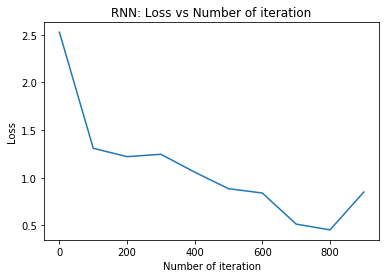

In [120]:
# visualization loss 
plt.plot(ite_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("RNN: Loss vs Number of iteration")
plt.show()